# 1. Import Libraries

In [ ]:
# data management libraries
import pandas as pd
import numpy as np

# visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# interactive visualizarion libaries
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# scikit learn clustering library
from sklearn.cluster import KMeans
# import the silhouette metric
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from matplotlib import style

#always :)
style.use("dark_background") 

# 2. Read Data 

In [ ]:
df = pd.read_csv('data/laptopPrice.csv')
df.head()

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,msoffice,Price,rating,Number of Ratings,Number of Reviews
0,ASUS,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,34649,2 stars,3,0
1,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,38999,3 stars,65,5
2,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,39999,3 stars,8,1
3,ASUS,Intel,Core i5,10th,8 GB,DDR4,512 GB,0 GB,Windows,32-bit,2 GB,Casual,No warranty,No,No,69990,3 stars,0,0
4,ASUS,Intel,Celeron Dual,Not Available,4 GB,DDR4,0 GB,512 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,26990,3 stars,0,0


In [ ]:
# check for missing values
df.isnull().sum()

brand                0
processor_brand      0
processor_name       0
processor_gnrtn      0
ram_gb               0
ram_type             0
ssd                  0
hdd                  0
os                   0
os_bit               0
graphic_card_gb      0
weight               0
warranty             0
Touchscreen          0
msoffice             0
Price                0
rating               0
Number of Ratings    0
Number of Reviews    0
dtype: int64

# 3. EDA

**Features:** 
- **brand:**   
    Brand name of the laptop manufacturer
- **processor_brand:**   
    Brand name of the laptop's cpu manufacturer
- **processor_name:**
    CPU model name
- **processor_gnrtn:**
    CPU generation:
- **ram_gb:**
- **ram_type**           
- **ssd**                
- **hdd**                
- **os**                 
- **os_bit**             
- **graphic_card_gb**    
- **weight**             
- **warranty**           
- **Touchscreen**        
- **msoffice**           
- **rating**             
- **Number of Ratings**  
- **Number of Reviews**  
- **Price:**     
    The target value.

In [ ]:
#show the data types of each column
df.dtypes

brand                object
processor_brand      object
processor_name       object
processor_gnrtn      object
ram_gb               object
ram_type             object
ssd                  object
hdd                  object
os                   object
os_bit               object
graphic_card_gb      object
weight               object
warranty             object
Touchscreen          object
msoffice             object
Price                 int64
rating               object
Number of Ratings     int64
Number of Reviews     int64
dtype: object

## Preprocessing

In [ ]:
for col in df.columns:
    if df[col].dtype == 'object':
        print(col, " unique values: ",df[col].unique())

brand  unique values:  ['ASUS' 'Lenovo' 'acer' 'Avita' 'HP' 'DELL' 'MSI' 'APPLE']
processor_brand  unique values:  ['Intel' 'AMD' 'M1']
processor_name  unique values:  ['Core i3' 'Core i5' 'Celeron Dual' 'Ryzen 5' 'Core i7' 'Core i9' 'M1'
 'Pentium Quad' 'Ryzen 3' 'Ryzen 7' 'Ryzen 9']
processor_gnrtn  unique values:  ['10th' 'Not Available' '11th' '7th' '8th' '9th' '4th' '12th']
ram_gb  unique values:  ['4 GB' '8 GB' '16 GB' '32 GB']
ram_type  unique values:  ['DDR4' 'LPDDR4' 'LPDDR4X' 'DDR5' 'DDR3' 'LPDDR3']
ssd  unique values:  ['0 GB' '512 GB' '256 GB' '128 GB' '1024 GB' '2048 GB' '3072 GB']
hdd  unique values:  ['1024 GB' '0 GB' '512 GB' '2048 GB']
os  unique values:  ['Windows' 'DOS' 'Mac']
os_bit  unique values:  ['64-bit' '32-bit']
graphic_card_gb  unique values:  ['0 GB' '2 GB' '4 GB' '6 GB' '8 GB']
weight  unique values:  ['Casual' 'ThinNlight' 'Gaming']
warranty  unique values:  ['No warranty' '1 year' '2 years' '3 years']
Touchscreen  unique values:  ['No' 'Yes']
msoffice  u

In [ ]:
#get unique triplets of 'processor_name''processor_brand','processor_gnrtn'
unique_combinations = df[['processor_name', 'processor_brand', 'processor_gnrtn']].drop_duplicates()
print(unique_combinations)


    processor_name processor_brand processor_gnrtn
0          Core i3           Intel            10th
3          Core i5           Intel            10th
4     Celeron Dual           Intel   Not Available
9          Ryzen 5             AMD            10th
14         Core i3           Intel            11th
16         Core i5           Intel            11th
22         Core i3           Intel             7th
23         Core i5           Intel             7th
85         Core i3           Intel             8th
196        Core i5           Intel   Not Available
205        Core i5           Intel             8th
253        Core i5           Intel             9th
423        Core i5           Intel             4th
478        Core i7           Intel             8th
485        Core i7           Intel            10th
489        Core i7           Intel            11th
532        Core i7           Intel             9th
547        Core i7           Intel            12th
587        Core i9           In

In [ ]:
#join the processor_name, processor_brand and processor_gnrtn columns into a single column
df['processor'] = df['processor_name'] + ' ' + df['processor_brand'] + ' ' + df['processor_gnrtn']
#drop the original columns
df = df.drop(columns=['processor_name', 'processor_brand', 'processor_gnrtn'])

Encode categorical values

In [ ]:
#convert to int and scale the values
df['ram_gb'] = df['ram_gb'].str.replace('GB','').astype(float).apply(lambda x: x/4)
df['ssd'] = df['ssd'].str.replace('GB','').astype(float).apply(lambda x: x/1024)
df['hdd'] = df['hdd'].str.replace('GB','').astype(float).apply(lambda x: x/1024)
df['graphic_card_gb'] = df['graphic_card_gb'].str.replace('GB','').astype(float).apply(lambda x: x/2)
df['rating'] = df['rating'].str.replace('stars','')
df['rating'] = df['rating'].str.replace('star','').astype(float)
df['warranty'] = df['warranty'].replace({'No warranty': 0, '1 year': 1, '2 years': 2, '3 years': 3})

In [ ]:
os_bit_mapping = {'32 bit': 0, '64 bit': 1}
df['os_bit'] = df['os_bit'].replace(os_bit_mapping)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
# df[['ram_gb', 'ssd', 'hdd', 'graphic_card_gb', 'rating', 'warranty']] = scaler.fit_transform(
#     df[['ram_gb', 'ssd', 'hdd', 'graphic_card_gb', 'rating', 'warranty']]
# )
df2=scaler.fit_transform(
    df[['ram_gb', 'ssd', 'hdd', 'graphic_card_gb', 'rating', 'warranty']]
)

In [ ]:
for col in df.columns:
    if df[col].dtype == 'object':
        #map the categorical values to numerical values
        #keep the mapping dictionary for future reference
        mapping_dict = {value: i for i, value in enumerate(df[col].unique())}
        df[col] = df[col].map(mapping_dict)
        #print the mapping dictionary
        print(f"Mapping for {col}: {mapping_dict}")


Mapping for brand: {'ASUS': 0, 'Lenovo': 1, 'acer': 2, 'Avita': 3, 'HP': 4, 'DELL': 5, 'MSI': 6, 'APPLE': 7}
Mapping for ram_type: {'DDR4': 0, 'LPDDR4': 1, 'LPDDR4X': 2, 'DDR5': 3, 'DDR3': 4, 'LPDDR3': 5}
Mapping for os: {'Windows': 0, 'DOS': 1, 'Mac': 2}
Mapping for os_bit: {'64-bit': 0, '32-bit': 1}
Mapping for weight: {'Casual': 0, 'ThinNlight': 1, 'Gaming': 2}
Mapping for Touchscreen: {'No': 0, 'Yes': 1}
Mapping for msoffice: {'No': 0, 'Yes': 1}
Mapping for processor: {'Core i3 Intel 10th': 0, 'Core i5 Intel 10th': 1, 'Celeron Dual Intel Not Available': 2, 'Ryzen 5 AMD 10th': 3, 'Core i3 Intel 11th': 4, 'Core i5 Intel 11th': 5, 'Core i3 Intel 7th': 6, 'Core i5 Intel 7th': 7, 'Core i3 Intel 8th': 8, 'Core i5 Intel Not Available': 9, 'Core i5 Intel 8th': 10, 'Core i5 Intel 9th': 11, 'Core i5 Intel 4th': 12, 'Core i7 Intel 8th': 13, 'Core i7 Intel 10th': 14, 'Core i7 Intel 11th': 15, 'Core i7 Intel 9th': 16, 'Core i7 Intel 12th': 17, 'Core i9 Intel 11th': 18, 'Core i9 Intel 12th': 19,

In [ ]:
df.columns

Index(['brand', 'ram_gb', 'ram_type', 'ssd', 'hdd', 'os', 'os_bit',
       'graphic_card_gb', 'weight', 'warranty', 'Touchscreen', 'msoffice',
       'Price', 'rating', 'Number of Ratings', 'Number of Reviews',
       'processor'],
      dtype='object')

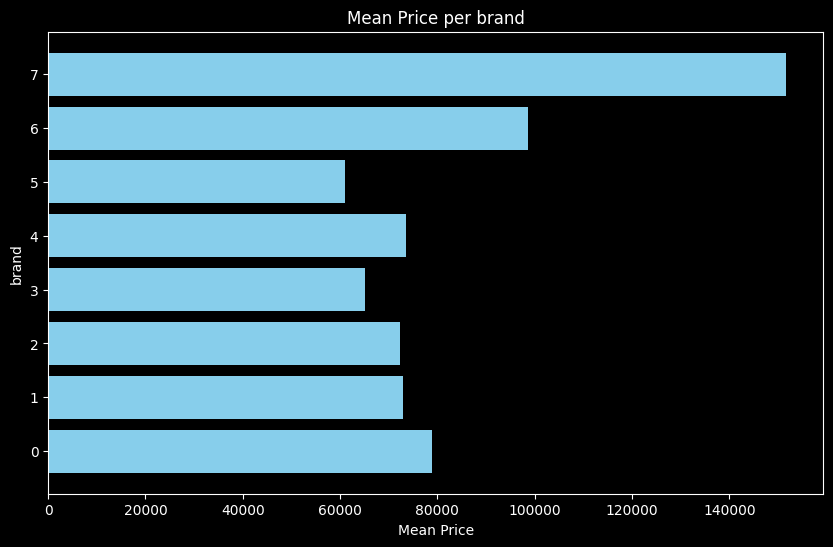

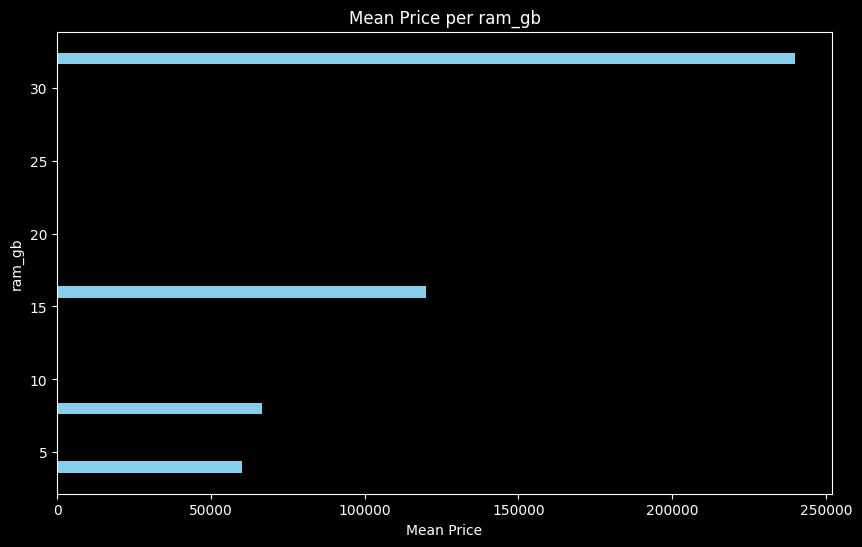

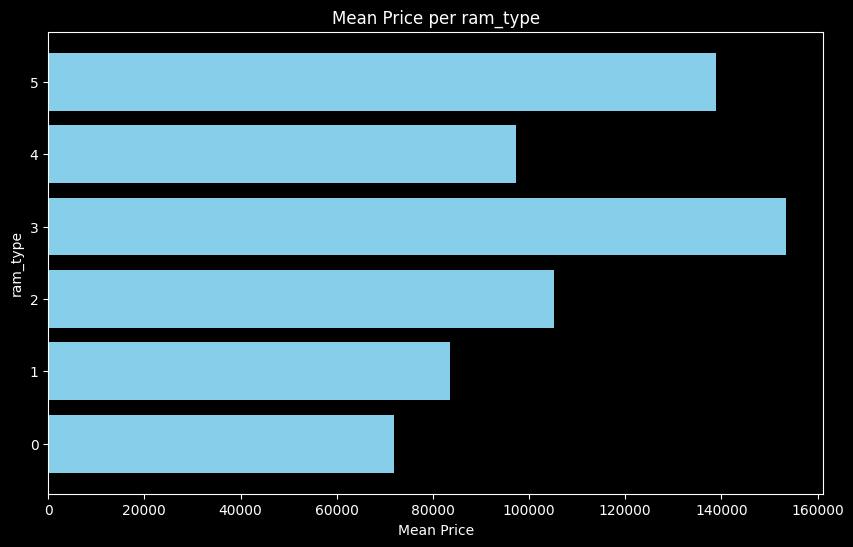

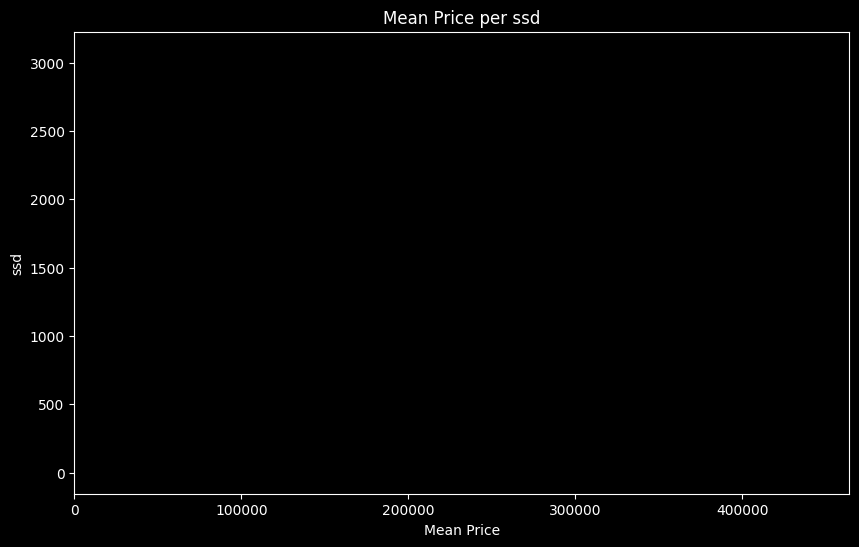

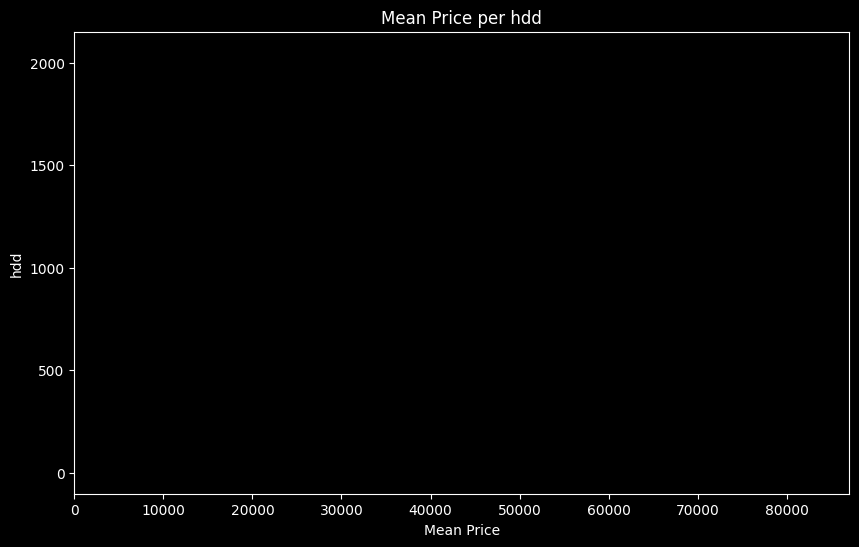

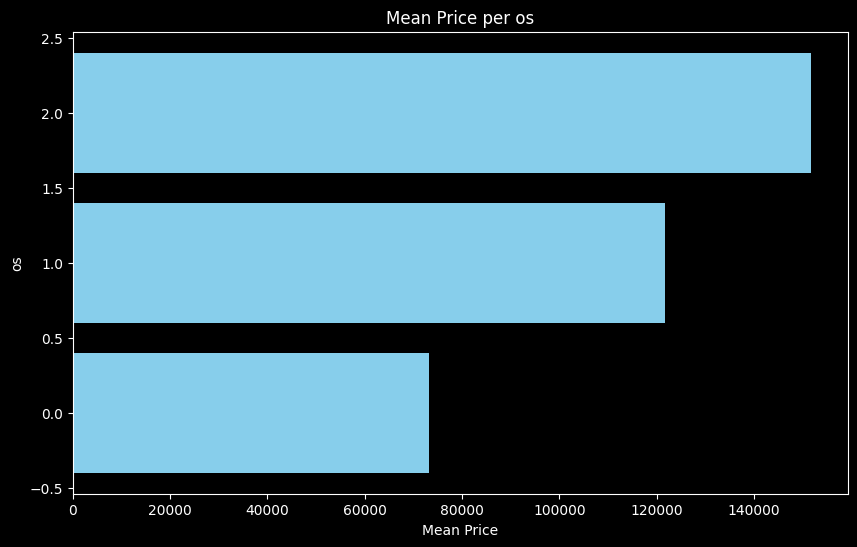

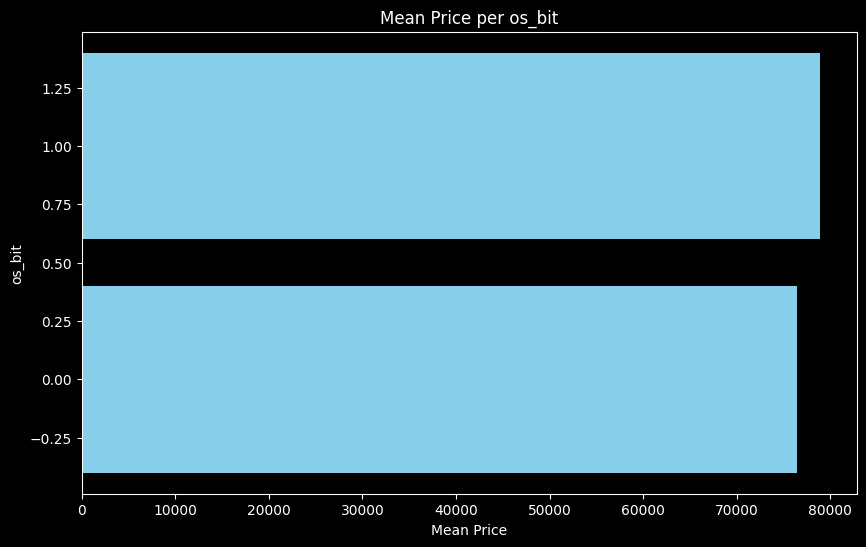

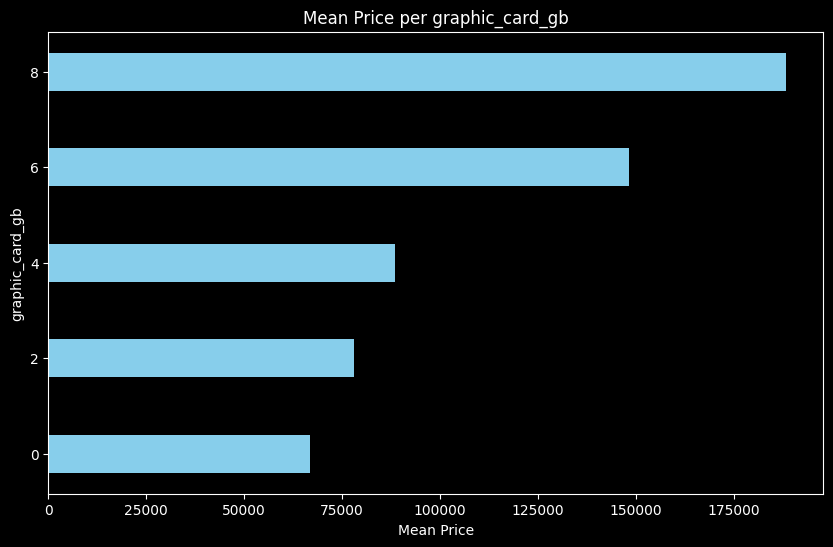

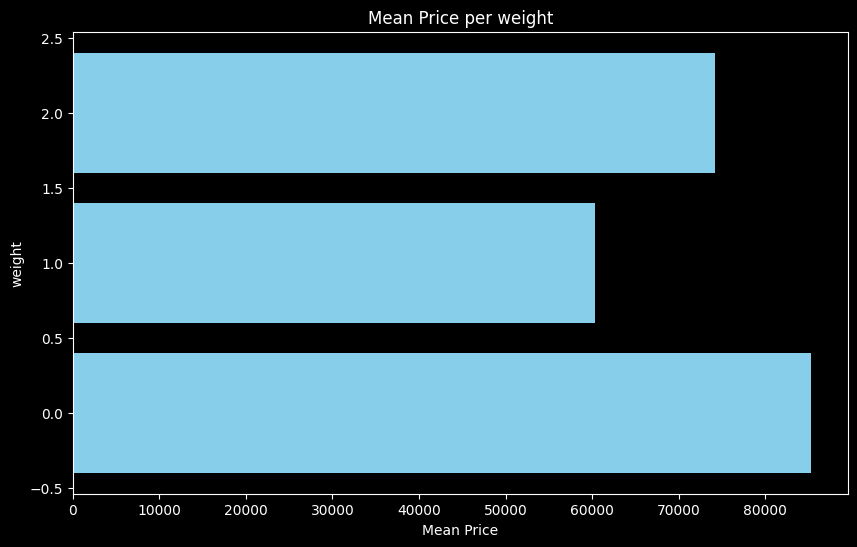

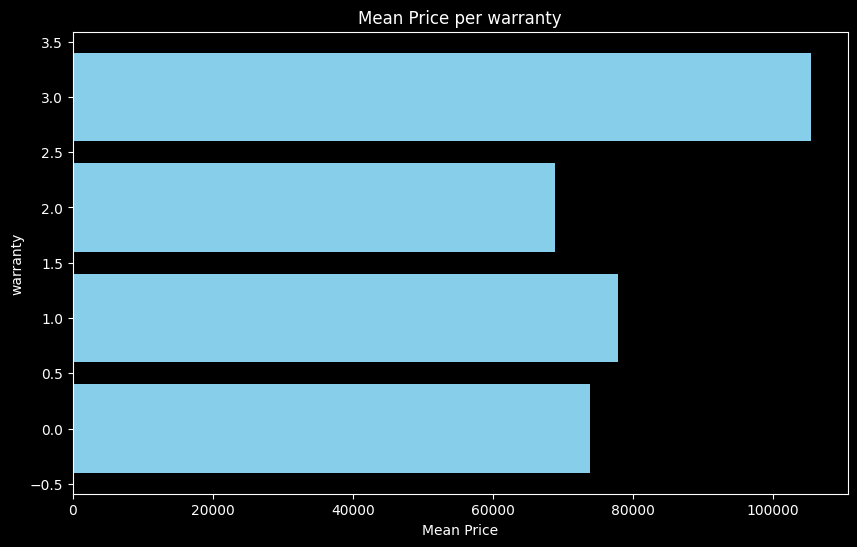

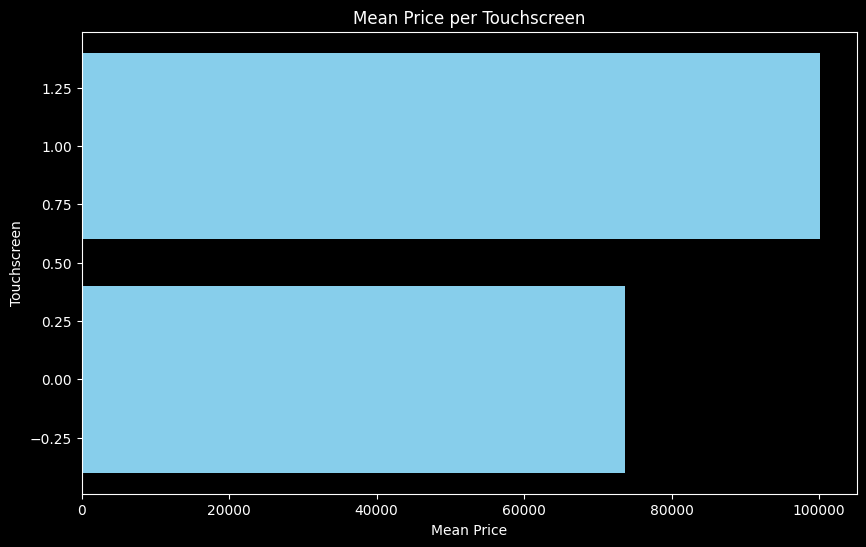

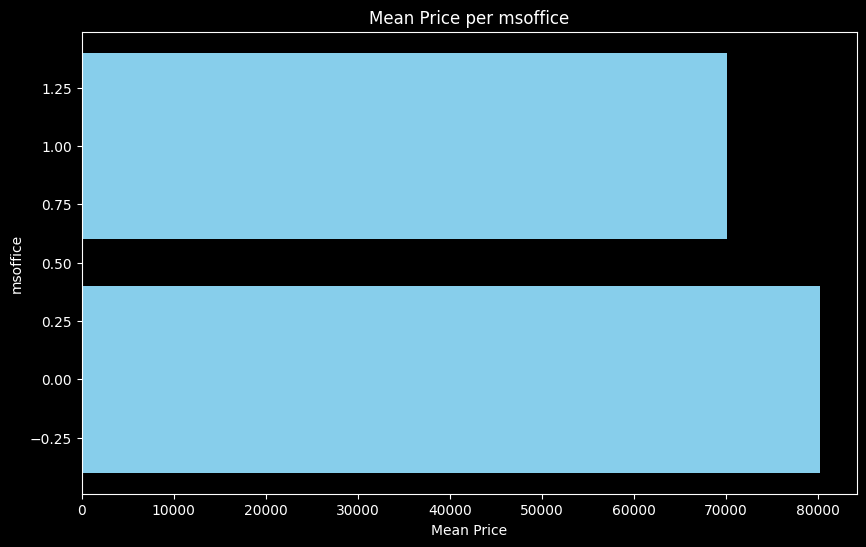

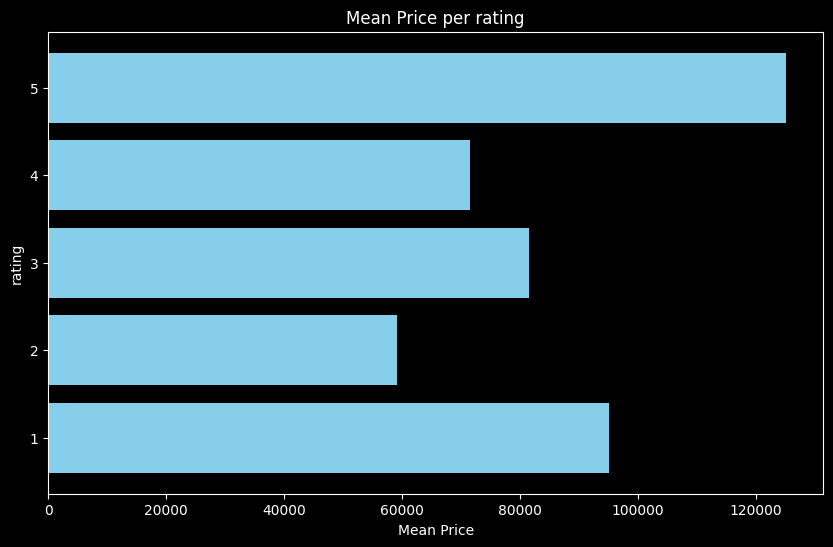

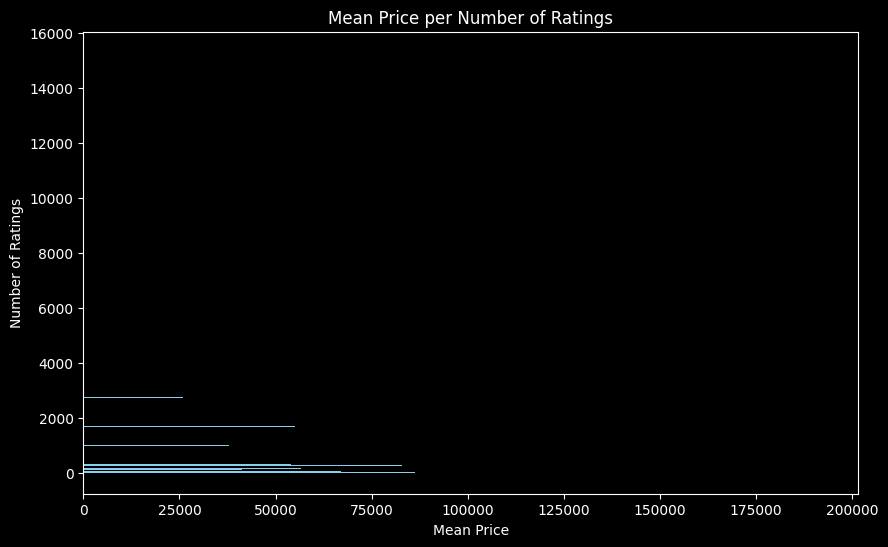

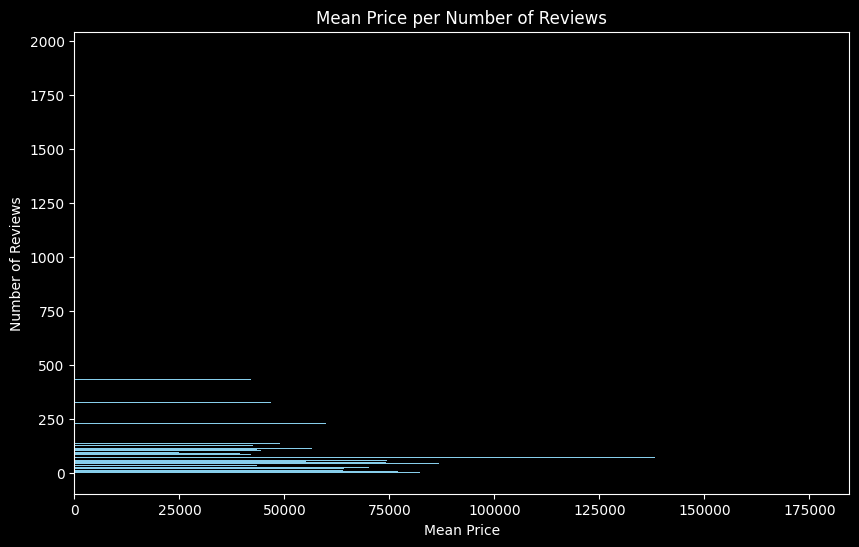

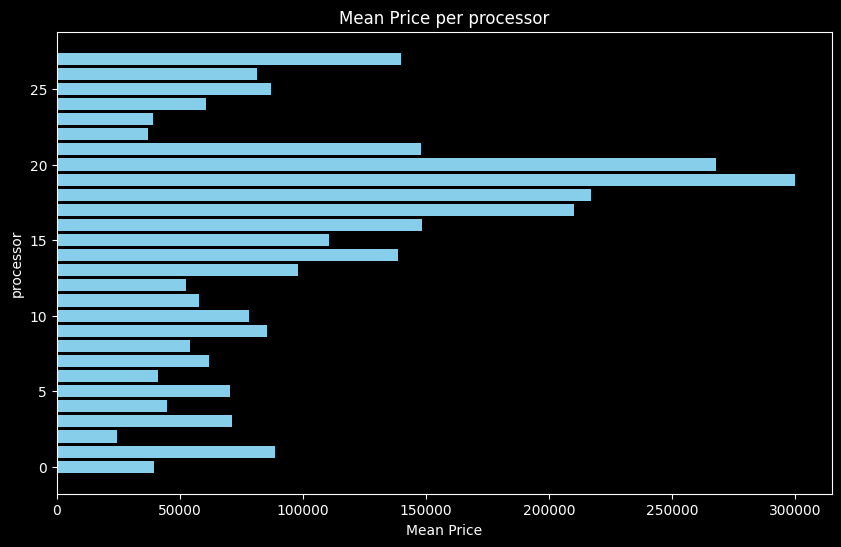

In [ ]:
for col in df.columns:
    #get mean price per each feature
    if col == 'Price':
        continue
    #get the mean price per feature
    mean_price = df.groupby(col)['Price'].mean().reset_index()
    mean_price = mean_price.sort_values(by='Price', ascending=False)
    #plot the mean price per processor
    plt.figure(figsize=(10, 6))
    plt.barh(mean_price[col], mean_price['Price'], color='skyblue')
    plt.xlabel('Mean Price')
    plt.ylabel(col)
    plt.title('Mean Price per ' + col)
    plt.show()
